In [1]:
# Dependencias necesarias
import keras
import pandas as pd
import numpy as np
# !pip install vaderSentiment
# !pip install wget
import wget
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /home/nbuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/nbuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nbuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Análisis emocional de texto

Analizaremos emociones o sentimientos de personas a traves de sus interacciones en medios digitales, en un tema determinado.

Nos enfocaremos en clasificar evaluaciones y determinar si esta es positiva, negativa o neutral, la dificultad corresponde a la ambigüedad latente del lenguaje e instancias de sentido no literal (sarcasmo, negaciones, etc).

Como fuente de datos usaremos una recopilación de opiniones de peliculas del sitio [rotten tomatoes](https://www.rottentomatoes.com/) organizado por la universidad de Stanford.

Comenzaremos solo con comentarios positivos o negativos, los cuales estaran clasificados como +1 o 0 respectivamente.


## Obtención de datos

Cargaremos los dos conjuntos de datos a trabajar, con la etiqueta ya codificada $0$ para el caso negativo y $1$ en caso positivo.

In [2]:
# Descargamos los conjuntos
train_url = "http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.train"
test_url = "http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.dev"
train = wget.download(train_url)
test = wget.download(test_url)

# Formateamos los conjuntos
def loading_data(filename):
    ftr = open(filename, "r", encoding="ISO-8859-1")
    rows = [line.split(" ",1) for line in ftr.readlines()]
    df = pd.DataFrame(rows,columns=['Sentiment', 'Text'])
    df['Sentiment'] = (pd.to_numeric(df['Sentiment']) + 1)/2
    return df

df_train = loading_data(train)
df_test = loading_data(test)

df_train_text = df_train.Text
df_test_text = df_test.Text
labels_train = df_train.Sentiment.values
labels_test = df_test.Sentiment.values

df_train.head()

,Sentiment,Text
0,0.0,"everything's serious , poetic , earnest and --..."
1,0.0,"narratively , trouble every day is a plodding ..."
2,1.0,a truly wonderful tale combined with stunning ...
3,1.0,jason patric and ray liotta make for one splen...
4,0.0,haneke keeps us at arm's length . guided more ...


In [3]:
df_test.head()

,Sentiment,Text
0,0.0,screenwriter dan schneider and director shawn ...
1,0.0,"home alone goes hollywood , a funny premise un..."
2,1.0,seldom has a movie so closely matched the spir...
3,0.0,"less dizzying than just dizzy , the jaunt is p..."
4,0.0,an ultra-low-budget indie debut that smacks mo...


##  Exploración de datos

Con los datos obtenidos, nos falta saber con que estamos traajando y sus dimensiones.

**df_train:** Corresponde al conjunto de entrenamiento el cual tiene dos columnas *Sentiment*, la cual corresponde al tipo de comentario si es positivo (1) o negativo (0), y *Text*, la cual corresponde al comentario en texto. Desde este conjunto se obtiene *df_train_text*, donde contiene solo los textos de los comentarios y *labels_train* donde solo contiene la clasificación de los comentarios (positivo o negativo) en su forma numérica.

**df_test:** Corresponde al conjunto de pruebas, su composición es idéntica a **df_train** y de él también se obtienen las derivadas *df_test_text* y *labels_test*.

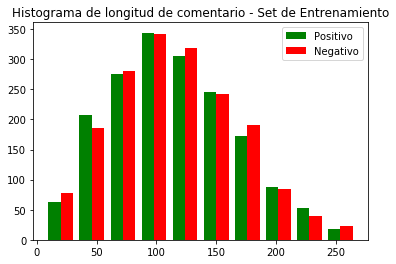

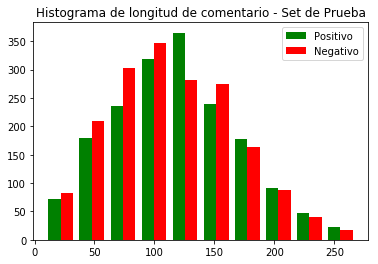

-- Dimensiones set de entrenamiento --
(3554, 2)
Promedio largo de comentario: 114.7071
Promedio calificación de comentario: 0.498
-- Dimensiones set de pruebas --
(3554, 2)
Promedio largo de comentario: 116.4679
Promedio calificación de comentario: 0.4927


In [4]:
avrg_train_len = 0
dep_train = [[],[]]
avrg_test_len = 0
dep_test = [[],[]]
for text,text2,scr,scr2 in zip(df_train.Text,df_test.Text,df_train.Sentiment,df_test.Sentiment):
    avrg_train_len += len(text)
    dep_train[0].append(len(text))
    dep_train[1].append(scr)
    avrg_test_len += len(text2)
    dep_test[0].append(len(text2))
    dep_test[1].append(scr2)

pos_train = list()
neg_train = list()
pos_test = list()
neg_test = list()
for a,b in zip(dep_train[0],dep_train[1]):
    if b == 1:
        pos_train.append(a)
    else:
        neg_train.append(a)
for a,b in zip(dep_test[0],dep_test[1]):
    if b == 1:
        pos_test.append(a)
    else:
        neg_test.append(a)

plt.hist([pos_train,neg_train],label=["Positivo","Negativo"],color=["g","red"])
plt.title("Histograma de longitud de comentario - Set de Entrenamiento")
plt.legend()
plt.show()

plt.hist([pos_test,neg_test],label=["Positivo","Negativo"],color=["g","red"])
plt.title("Histograma de longitud de comentario - Set de Prueba")
plt.legend()
plt.show()

print("-- Dimensiones set de entrenamiento --")
print(df_train.shape)
print("Promedio largo de comentario:",round(avrg_train_len/df_train.shape[0],4))
print("Promedio calificación de comentario:",round(np.average(dep_train[1]),4))
print("-- Dimensiones set de pruebas --")
print(df_test.shape)
print("Promedio largo de comentario:",round(avrg_test_len/df_test.shape[0],4))
print("Promedio calificación de comentario:",round(np.average(dep_test[1]),4))

## Conjunto de validación

Para seleccionar modelos necesitaremos un conjunto capaz de validarlos, en esta sección dispondremos de uno

In [5]:
from sklearn.model_selection import train_test_split
df_train_text, df_val_text, labels_train, labels_val = train_test_split(df_train_text, labels_train, test_size=1000, random_state=0)
print("Tamaño set validación:", df_val_text.shape[0])
print("Tamaño set entrenamiento:", df_train_text.shape[0])

Tamaño set validación: 1000
Tamaño set entrenamiento: 2554


## Normalización de los datos

La idea en eliminar los artículos en conjunto con pronombres y preposiciones, es obtener solo los adjetivos y sustantivos los cuales son más ricos en contenido así como claves para determinar el sentido detras del comentario, esto no quiere decir que elimine la ambigüedad del lenguaje.

In [6]:
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize

def base_word(word):
    wordlemmatizer = WordNetLemmatizer()
    return wordlemmatizer.lemmatize(word) 

def word_extractor(text):
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text) #substitute multiple letter by two
    words = ""
    wordtokens = [ base_word(word.lower()) for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in commonwords: #delete stopwords
            words+=" "+word
    return words

print("-- Normalización de texto --")
print("Original: is an unabridged republication of the work originally")
print("Normalizado:",word_extractor("is an unabridged republication of the work originally"))
print("Original: contain more actual wisdom than the whole body of English learning")
print("Normalizado:",word_extractor("contain more actual wisdom than the whole body of English learning"))

texts_train = [word_extractor(text) for text in df_train_text]
texts_val = [word_extractor(text) for text in df_val_text]
texts_test = [word_extractor(text) for text in df_test_text]

-- Normalización de texto --
Original: is an unabridged republication of the work originally
Normalizado:  unabridged republication work originally
Original: contain more actual wisdom than the whole body of English learning
Normalizado:  contain actual wisdom whole body english learning


## Representación vectorial de las entradas

Para poder clasificar más fácilmente, contaremos cuantas veces aparece cada palabra en el texto (*term-frequency*), por lo cual construiremos un diccionario observando los textos de entrenamiento.

In [7]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 1), binary=False)
vectorizer.fit(texts_train)
features_train = vectorizer.transform(texts_train)
vocab_train = vectorizer.get_feature_names()
dist_train=list(np.array(features_train.sum(axis=0)).reshape(-1,))
data = list()
for a,b in zip(vocab_train,dist_train):
    data.append([a,b])
df_dist_train = pd.DataFrame(data,columns=["Palabra","Repeticiones"])
a = df_dist_train.sort_values(by=['Repeticiones'],ascending=False).head(10)
print("-- Distibución conjunto de entrenamiento --")
print(a)
print()

features_test = vectorizer.transform(texts_test)
vocab_test = vectorizer.get_feature_names()
dist_test=list(np.array(features_test.sum(axis=0)).reshape(-1,))
data = list()
for a,b in zip(vocab_test,dist_test):
    data.append([a,b])
df_dist_test = pd.DataFrame(data,columns=["Palabra","Repeticiones"])
a = df_dist_test.sort_values(by=['Repeticiones'],ascending=False).head(10)
print("-- Distibución conjunto de prueba --")
print(a)
print()

features_val = vectorizer.transform(texts_val)
vocab_val = vectorizer.get_feature_names()
dist_val = list(np.array(features_val.sum(axis=0)).reshape(-1,))
data = list()
for a,b in zip(vocab_val,dist_val):
    data.append([a,b])
df_dist_val = pd.DataFrame(data,columns=["Palabra","Repeticiones"])
a = df_dist_val.sort_values(by=['Repeticiones'],ascending=False).head(10)
print("-- Distibución conjunto de validación --")
print(a)
print()

#print(features_test.shape)
#print(features_train.shape)
#print(features_val.shape)


-- Distibución conjunto de entrenamiento --
        Palabra  Repeticiones
2734       film           431
4687      movie           357
4962        one           188
3238         ha           170
4193       like           169
4361       make           144
6815      story           132
1124  character           123
3100       good           107
2454       even           106

-- Distibución conjunto de prueba --
        Palabra  Repeticiones
2734       film           581
4687      movie           568
4962        one           259
3238         ha           246
4193       like           239
6815      story           204
1124  character           178
7243       time           176
4361       make           167
3100       good           142

-- Distibución conjunto de validación --
     Palabra  Repeticiones
2734    film           153
4687   movie           146
4193    like            86
4962     one            71
3238      ha            65
7243    time            51
2060     doe            47


### Representación LSA

Esta representación refuerza lo hecho anteriormente, al visualizar en 2D.

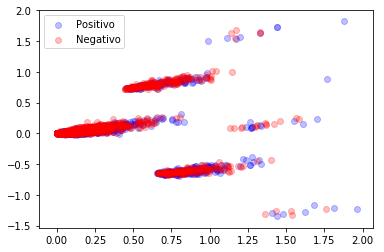

In [8]:
from sklearn.decomposition import TruncatedSVD

model = TruncatedSVD(n_components=2)
model.fit(features_train)
x_plot = model.transform(features_train)

puntos = [[[],[]],[[],[]]]
for point,label in zip(x_plot,labels_train):
    if label == 1:
        puntos[0][0].append(point[0])
        puntos[0][1].append(point[1])
    else:
        puntos[1][0].append(point[0])
        puntos[1][1].append(point[1])

plt.figure()
plt.scatter(puntos[0][0],puntos[0][1],label="Positivo",alpha=0.25,color="Blue")
plt.scatter(puntos[1][0],puntos[1][1],label="Negativo",alpha=0.25,color="Red")
plt.legend()
plt.show()

Podemos notar concentración de datos en 3 sectores, con lo cual podemos inferir correlación positiva entre estos. Además podemos observar outliers, tanto positivos como negativos

## Modelo de regresión Logística

Haremos uso de un modelo de regresión logística regularizado con una norma $l_2$ usada de penalizador.

Param C=  0.0001
Param C=  0.001
Param C=  0.01
Param C=  0.1
Param C=  1.0
Param C=  10.0
Param C=  100.0


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Param C=  1000.0


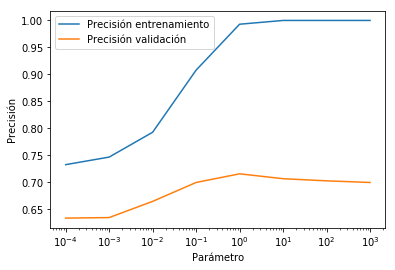

In [9]:
from sklearn.linear_model import LogisticRegression

def do_LOGIT(x,y,xv,yv, param):
    print("Param C= ",param)
    model= LogisticRegression()
    model.set_params(C=param)
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc

Cs = [10**i for i in np.arange(-4,4, dtype=float)]
acc_val = list()
acc_train = list()
for rango in Cs:
    _, train_acc, test_acc = do_LOGIT(features_train,labels_train,features_val,labels_val, param=rango)
    acc_train.append(round(train_acc,3))
    acc_val.append(round(test_acc,3))

plt.plot(Cs, acc_train, label = "Precisión entrenamiento")
plt.plot(Cs, acc_val, label = "Precisión validación")
plt.xlabel("Parámetro")
plt.ylabel("Precisión")
plt.xscale('log')
plt.legend()
plt.show()

Podemos observar en el gráfico al aumentar el valor del parámetro la precisión de entrenamiento aumenta, pero en el caso de validación solo crece hasta $10^0$, luego comienza a descender.

Además debemos tener en cuenta el aumento del parámetro, puesto causa *overfitting* en el modelo obtenido.

## Modelo "Máquina de Soporte Vectorial (SVM)"

Ahora haremos uso de modelos que utilicen kernels, el procedimiento será similar a los métodos lineales donde analizamos el parámetro de regulrización $C$.

Param C = 0.0001 Kernel = linear
Param C = 0.001 Kernel = linear
Param C = 0.01 Kernel = linear
Param C = 0.1 Kernel = linear
Param C = 1.0 Kernel = linear
Param C = 10.0 Kernel = linear
Param C = 100.0 Kernel = linear
Param C = 1000.0 Kernel = linear


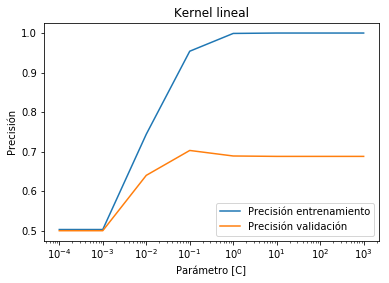

Param C = 0.0001 Kernel = poly


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C = 0.001 Kernel = poly
Param C = 0.01 Kernel = poly
Param C = 0.1 Kernel = poly
Param C = 1.0 Kernel = poly
Param C = 10.0 Kernel = poly
Param C = 100.0 Kernel = poly
Param C = 1000.0 Kernel = poly


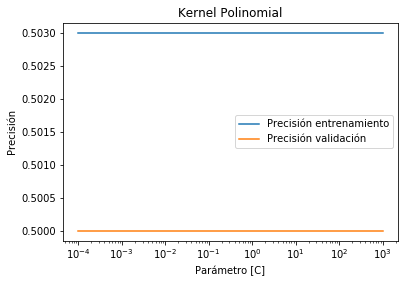

Param C = 0.0001 Kernel = rbf
Param C = 0.001 Kernel = rbf
Param C = 0.01 Kernel = rbf
Param C = 0.1 Kernel = rbf
Param C = 1.0 Kernel = rbf
Param C = 10.0 Kernel = rbf
Param C = 100.0 Kernel = rbf
Param C = 1000.0 Kernel = rbf


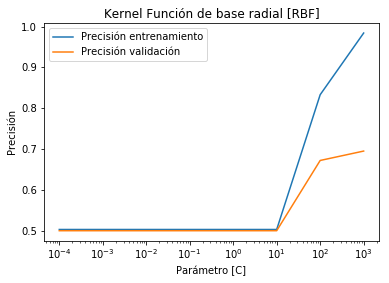

Param C = 0.0001 Kernel = sigmoid
Param C = 0.001 Kernel = sigmoid
Param C = 0.01 Kernel = sigmoid
Param C = 0.1 Kernel = sigmoid
Param C = 1.0 Kernel = sigmoid
Param C = 10.0 Kernel = sigmoid
Param C = 100.0 Kernel = sigmoid
Param C = 1000.0 Kernel = sigmoid


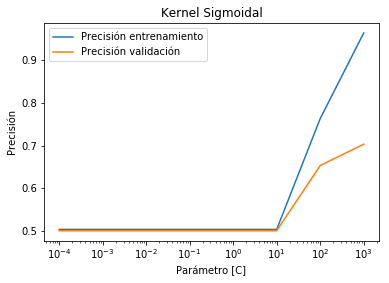

In [10]:
from sklearn.svm import SVC as SVM #SVC is for classification

def do_SVM(x,y,xv,yv, param, kernel='linear'):
    print("Param C =",param, 'Kernel =', kernel)
    model= SVM()
    model.set_params(C=param,kernel=kernel) #try rbf and linear at least
    model.fit(x,y)
    train_acc = model.score(x,y)
    val_acc = model.score(xv,yv)
    return model, train_acc, val_acc

def graficar(ft,lt,fv,lv,k):
    Cs = [10**i for i in np.arange(-4,4, dtype=float)]
    acc_val = list()
    acc_train = list()
    for rango in Cs:
        _, train_acc, test_acc = do_SVM(ft,lt,fv,lv, param=rango,kernel=k)
        acc_train.append(round(train_acc,3))
        acc_val.append(round(test_acc,3))
    return acc_train,acc_val

train_acc, val_acc = graficar(features_train,labels_train,features_val,labels_val,'linear')
plt.plot(Cs,train_acc,label = 'Precisión entrenamiento')
plt.plot(Cs,val_acc,label = 'Precisión validación')
plt.title('Kernel lineal')
plt.xlabel('Parámetro [C]')
plt.ylabel('Precisión')
plt.xscale('log')
plt.legend()
plt.show()

train_acc, val_acc = graficar(features_train,labels_train,features_val,labels_val,'poly')
plt.plot(Cs,train_acc,label = 'Precisión entrenamiento')
plt.plot(Cs,val_acc,label = 'Precisión validación')
plt.title('Kernel Polinomial')
plt.xlabel('Parámetro [C]')
plt.ylabel('Precisión')
plt.xscale('log')
plt.legend()
plt.show()

train_acc, val_acc = graficar(features_train,labels_train,features_val,labels_val,'rbf')
plt.plot(Cs,train_acc,label = 'Precisión entrenamiento')
plt.plot(Cs,val_acc,label = 'Precisión validación')
plt.title('Kernel Función de base radial [RBF]')
plt.xlabel('Parámetro [C]')
plt.ylabel('Precisión')
plt.xscale('log')
plt.legend()
plt.show()

train_acc, val_acc = graficar(features_train,labels_train,features_val,labels_val,'sigmoid')
plt.plot(Cs,train_acc,label = 'Precisión entrenamiento')
plt.plot(Cs,val_acc,label = 'Precisión validación')
plt.title('Kernel Sigmoidal')
plt.xlabel('Parámetro [C]')
plt.ylabel('Precisión')
plt.xscale('log')
plt.legend()
plt.show()

### Análisis

#### Kernel Lineal
Podemos notar que desde $10^{-3}$, comienza a mejorar la precisión, en donde para el set de validación tiene su punto más favorecedor en $10^{-1}$ y para el set de entrenamiento en $10^0$

#### Kernel Polinomial
Notamos que ambas precisiones se mantienen constantes para cada conjunto de datos sin haber cambios significantes

#### Kernel RBF (Función de base radial)
Observamos que hay mejora desde el valor $10^1$ para el parámetro, hay un crecimiento rápido hasta $10^2$, el cual se hace menor hacia adelante pero es continuado

#### Kernel Sigmoidal
Muy similar al kernel *RBF*, en donde podemos apreciar un crecimiento después de $10^1$, el cual crece de manera continuada

#### Conclusiones
En la mayoría de los casos podemos notar que al aumentar el valor del parámetro la precisión aumenta, además cabe notar que a valores muy pequeños el comportamiento del modelo es aleatorio.

## Algortimo k-NN (k Nearest Neighbour)
Similar a las secciones anteriores usaremos el algoritmo *k-NN*, y veremos el comportamiento del parámetro en función de la precisión de predicción.

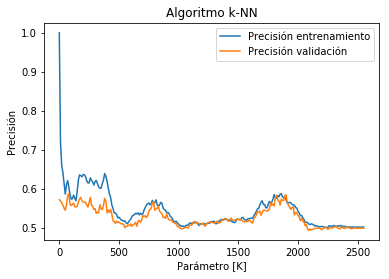

In [11]:
from sklearn.neighbors import KNeighborsClassifier

def do_KNN(x,y,xv,yv, param):
    model = KNeighborsClassifier()
    # print("Param K= ",param)
    model.set_params(n_neighbors=param)
    model.fit(x,y)
    train_acc = model.score(x,y)
    val_acc = model.score(xv,yv)
    return model, train_acc, val_acc

steps = 10
Ks = np.arange(1, features_train.shape[0], steps)

def graficar(x,y,xv,yv,Ks):
    acc_train = list()
    acc_val = list()
    for par in Ks:
        model, train_acc, val_acc = do_KNN(x,y,xv,yv,par)
        acc_train.append(train_acc)
        acc_val.append(val_acc)
    return model,acc_train,acc_val

model,train_acc,val_acc = graficar(features_train,labels_train,features_val,labels_val,Ks)
plt.plot(Ks,train_acc,label = 'Precisión entrenamiento')
plt.plot(Ks,val_acc,label = 'Precisión validación')
plt.title('Algoritmo k-NN')
plt.xlabel('Parámetro [K]')
plt.ylabel('Precisión')
plt.legend()
# plt.xscale('log')
plt.show()

Como podemos apreciar el valor del parámetro al aumentar solo disminuye la precisión del modelo, por ende, tan solo nos queda usar un valor cercano a los iniciales.

## Árbol de decisión
Entrenaremos un árbol de decisión variando sus parámetros (profundidad y cantidad de mmuestras) y graficaremos sus errores

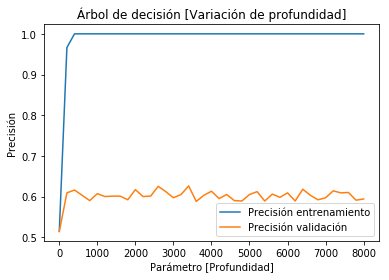

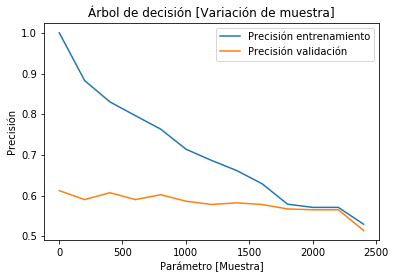

In [12]:
from sklearn.tree import DecisionTreeClassifier as Tree
def do_Tree(x,y,xv,yv, param_d=None, param_m=2):
    model = Tree()
    # print("Param Max-D= ",param_d, 'Min-samples-S= ', param_m)
    model.set_params(max_depth=param_d, min_samples_split=param_m) 
    model.fit(x,y)
    train_acc = model.score(x,y)
    val_acc = model.score(xv,yv)
    return model, train_acc, val_acc

steps=200
Depths = np.arange(1, features_train.shape[1], steps)
Samples = np.arange(2, features_train.shape[0] , steps)

def graficar(x,y,xv,yv,D,S):
    Depth_train = []
    Depth_val =  []
    Sample_train = []
    Sample_val = []
    for par in D:
        model, train_acc, val_acc = do_Tree(features_train,labels_train,features_val,labels_val,par)
        Depth_train.append(train_acc)
        Depth_val.append(val_acc)
    for par in S:
        model, train_acc, val_acc = do_Tree(features_train,labels_train,features_val,labels_val,None,par)
        Sample_train.append(train_acc)
        Sample_val.append(val_acc) 
    return Depth_train,Depth_val,Sample_train,Sample_val

Depth_train,Depth_val,Sample_train,Sample_val = graficar(features_train,labels_train,features_val,labels_val,Depths,Samples)

plt.plot(Depths,Depth_train,label = 'Precisión entrenamiento')
plt.plot(Depths,Depth_val,label = 'Precisión validación')
plt.title('Árbol de decisión [Variación de profundidad]')
plt.xlabel('Parámetro [Profundidad]')
plt.ylabel('Precisión')
plt.legend()
# plt.xscale('log')
plt.show()

plt.plot(Samples,Sample_train,label = 'Precisión entrenamiento')
plt.plot(Samples,Sample_val,label = 'Precisión validación')
plt.title('Árbol de decisión [Variación de muestra]')
plt.xlabel('Parámetro [Muestra]')
plt.ylabel('Precisión')
plt.legend()
# plt.xscale('log')
plt.show()

En el primer gráfico notamos que la variación de la densidad no influye en al aumentar más allá de valores mayores a $1000$.

En cuanto a la cantidad de muestras, el gráfico solo desciende en precisión del conjunto de entrenamiento manteniendo la precisión en el conjunto de validación, esto nos indica que para valores cercanos a $0$ el ajuste es óptimo.

## Red Neuronal Artificial (ANN)

Utilizaremos una ANN, la cual será entrenada por 25 iteraciones al conjunto de datos.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


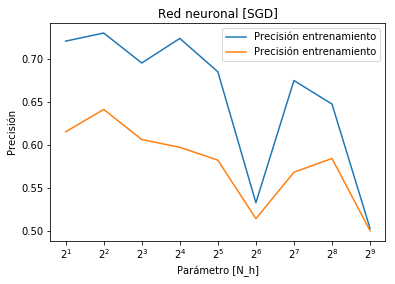

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

def do_ANN(x,y, xv,yv, param):
    #print("Neuron hidden = ",param)
    model = Sequential()
    model.add(Dense(units=param, input_dim=x.shape[1], activation="sigmoid"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(x, y, epochs=25, batch_size=128, verbose=0)
    train_acc = model.evaluate(x,y, verbose=0)[1] #in position 0 is the loss
    val_acc = model.evaluate(xv,yv, verbose=0)[1]
    return model, train_acc, val_acc

N_h = [2**int(i) for i in range(1,10)]


def graficar(x,y,xv,yv,N_h):
    acc_train = []
    acc_val =  []
    for par in N_h:
        model, train_acc, val_acc = do_ANN(features_train,labels_train,features_val,labels_val,par)
        acc_train.append(train_acc)
        acc_val.append(val_acc)
    return model,acc_train,acc_val

model,train_acc, val_acc = graficar(features_train,labels_train,features_val,labels_val,N_h)
plt.plot(N_h,train_acc,label = 'Precisión entrenamiento')
plt.plot(N_h,val_acc,label = 'Precisión entrenamiento')
plt.title('Red neuronal [SGD]')
plt.xlabel('Parámetro [N_h]')
plt.ylabel('Precisión')
plt.legend()
plt.xscale('log', basex=2)
plt.show()

Al observar el gráfico, al aumentar la cantidad de neuronas la precisión disminuye de forma persistente, lo cual nos dice que cualquier valor mayor a $2^2$ de neuronas es inadecuado.

## Evaluación mejor modelo

De los modelos anteriores, podemos decir que el modelo de regresión tuvo mejor éxito entre las laternativas disponibles, teniendo en promedio un valor del $70\%$ de precisión en el conjunto de validación.
Ahora haremos uso del set de pruebas para verificar que este comportamiento es constante.

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


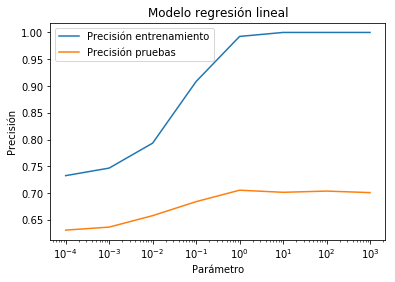

In [14]:
from sklearn.svm import SVC as SVM #SVC is for classification

def do_LOGIT(x,y,xv,yv, param):
    #print("Param C= ",param)
    model= LogisticRegression()
    model.set_params(C=param)
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc
Cs = [10**int(i) for i in np.arange(-4,4)]

def graficar(x,y,xv,yv,Cs):
    
    acc_train = []
    acc_test =  []
    for par in Cs:
        model, train_acc, test_acc = do_LOGIT(features_train,labels_train,features_test,labels_test,par)
        model.probaility = True
        acc_train.append(train_acc)
        acc_test.append(test_acc)
    return model,acc_train,acc_test

model,train_acc, test_acc = graficar(features_train,labels_train,features_test,labels_test,Cs)
plt.plot(Cs, train_acc, label = "Precisión entrenamiento")
plt.plot(Cs, test_acc, label = "Precisión pruebas")
plt.xlabel("Parámetro")
plt.ylabel("Precisión")
plt.xscale('log')
plt.legend()
plt.title("Modelo regresión lineal")
plt.show()

Como podemos observar desde el gráfico la precisión en el conjunto de pruebas tiene un peak de $0.7$ con un valor de parámetro $10^0$

## Modelo VADER

Usaremos un modelo que entrega un scroe de prediccción a nivel léxico (asociaciones con las palabras de forma más directa con su significado).

In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

def vader_predict(sentences): 
    sid_obj = SentimentIntensityAnalyzer() 
    sent_v = []
    for text in sentences:
        sentiment_dict = sid_obj.polarity_scores(text) 
        if sentiment_dict["pos"] > sentiment_dict["neg"]: #based on scores
            sent_v.append(1)
        else:
            sent_v.append(0)
    return np.asarray(sent_v)

vader_pred_test = vader_predict(df_test_text) 

from sklearn.metrics import accuracy_score

print("Precisión VADER:",round(accuracy_score(labels_test, vader_pred_test),3))

Precisión VADER: 0.636


Con este método obtuvimos una peor precisión, por lo cual nuestro método de regresión lineal sigue siendo nuestra primera opción a utiizar

## Análisis de vocabulario

Consideraremos que palabras nuestro modelo denomina positivas o negativas.

In [16]:
V = len(vocab_train)
word_scores = np.zeros((V, 2))
for i in range(V):
    x_word = np.zeros((1, V))
    x_word[:,i] = 1 # only the "i" word appeared
    word_scores[i] = model.predict_proba(x_word)

kpos = word_scores[word_scores[:,0].argsort()]
kneg = word_scores[word_scores[:,1].argsort()]

pos_neg = []
pos_pos = []

wpos = []
wneg = []

for i in range(10):
    index_pos = np.where(word_scores == kpos[i])
    index_neg = np.where(word_scores == kneg[i])
    wpos.append(vocab_train[index_pos[0][0]])
    wneg.append(vocab_train[index_neg[0][0]])

print("-- Palabras más positivas --")
i = 1
for a in wpos:
    print(i,")",a)
    i += 1
print("\n-- Palabras más negativas --")
i = 1
for a in wneg:
    print(i,")",a)
    i += 1

-- Palabras más positivas --
1 ) skillful
2 ) witty
3 ) still
4 ) openness
5 ) dense
6 ) solid
7 ) engage
8 ) stitch
9 ) world
10 ) marvel

-- Palabras más negativas --
1 ) worst
2 ) apparent
3 ) dull
4 ) devoid
5 ) cliche
6 ) comedic
7 ) pretentious
8 ) plodding
9 ) feel
10 ) bad


Las palabras son muy explicativas en si, en cuanto a las positivas muestran dotes y cualidades, en contrario, las palabras negativas recalcan características negativas. 
Cabe destacar que ambos conjuntos no tienen palabras en común, lo cual es un buen signo.

## Cambio de pre-procesamiento

Variamos la técnica de pre-procesamiento de los datos y usaremos un método diferente (stemming), anteriormente utilizamos lemmatization.

In [17]:
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from nltk.stem.porter import PorterStemmer

def base_word(word):
    wordstemmer = PorterStemmer()
    return wordstemmer.stem(word)

def word_extractor(text):
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text) #substitute multiple letter by two
    words = ""
    wordtokens = [ base_word(word.lower()) for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in commonwords: #delete stopwords
            words+=" "+word
    return words

print("-- Pre-processamiento de texto [stemming] --")
print("Original: is an unabridged republication of the work originally")
print("Normalizado:",word_extractor("is an unabridged republication of the work originally"))
print("Original: contain more actual wisdom than the whole body of English learning")
print("Normalizado:",word_extractor("contain more actual wisdom than the whole body of English learning"))

texts_train = [word_extractor(text) for text in df_train_text]
texts_val = [word_extractor(text) for text in df_val_text]
texts_test = [word_extractor(text) for text in df_test_text]

-- Pre-processamiento de texto [stemming] --
Original: is an unabridged republication of the work originally
Normalizado:  unabridg republ work origin
Original: contain more actual wisdom than the whole body of English learning
Normalizado:  contain actual wisdom whole bodi english learn


## Reducción de vocabulario

Realizaremos una reducción en cuanto al vocabulario disponible, esto ayudará al rendimiento general.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(binary=False, ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, norm='l2', use_idf=True, sublinear_tf=False)
tfidf_model.fit(texts_train)
features_train = tfidf_model.transform(texts_train)
features_val = tfidf_model.transform(texts_val)
features_test = tfidf_model.transform(texts_test)
model, train_acc, val_acc = do_LOGIT(features_train,labels_train,features_val,labels_val,1)

print(train_acc, val_acc)

0.937744714173845 0.709


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Análisis de Fallas

Usaremos métricas externas para entender los motivos de error en el modelo obtenido hasta el momento

In [19]:
from sklearn.metrics import classification_report
def score_the_model(model, x, y):
    print("Detailed Analysis Testing Results ...")
    print(classification_report(y, model.predict(x), target_names=['-','+']))
score_the_model(model, features_test, labels_test )

Detailed Analysis Testing Results ...
              precision    recall  f1-score   support

           -       0.73      0.74      0.73      1803
           +       0.73      0.72      0.72      1751

   micro avg       0.73      0.73      0.73      3554
   macro avg       0.73      0.73      0.73      3554
weighted avg       0.73      0.73      0.73      3554



Observamos un buen comportamiento en general, tanto en clasificación negativa como positiva, todas con un valor de precisión mayor a $0.72$

## Clase con pesos

Haremos uso de pesos para aumentar el interés de una clase por sobre otra, en este caso diremos que la clase negativa es $5$ veces más importante que su contraparte

In [20]:
classes_weights = {0: 5, 1: 1}
model.set_params(class_weight=classes_weights)
model.fit(features_train, labels_train)
score_the_model(model, features_test, labels_test)

Detailed Analysis Testing Results ...
              precision    recall  f1-score   support

           -       0.54      0.99      0.70      1803
           +       0.94      0.14      0.24      1751

   micro avg       0.57      0.57      0.57      3554
   macro avg       0.74      0.57      0.47      3554
weighted avg       0.74      0.57      0.48      3554



Como podemos observar, la precisión de la clase positiva aumentó de forma significativa, pero la clase negativa bajó en su precisión en la misma cantidad. El recall de comentarios positivos es muy bajo, esta cifra nos dice que perderemos un $85\%$ de esta clase de forma aproximada.

En resumidas cuentas el clasificador es muy bueno si solo queremos obtener elementos de la clase negativas, pero su porcentaje de error es alto de todas maneras.

## Tipo de predicción

Hasta ahora no nos hemos preguntado por el tipo de clasificación usado, pausaremos a ver si una predicción categórica es la adecuada por sobre una continua o no.

In [21]:
test_pred = model.predict_proba(features_test)
spl = np.random.randint( 0, len(test_pred), size=15)
for text, pred_s, true_s in zip(df_test_text[spl], test_pred[spl], labels_test[spl]):
    print("True sent: ", true_s, "-- Pred sent: ", pred_s)
    print("Raw text: ", text)

True sent:  0.0 -- Pred sent:  [0.76670769 0.23329231]
Raw text:  a few hours after you've seen it , you forget you've been to the movies .

True sent:  1.0 -- Pred sent:  [0.41299377 0.58700623]
Raw text:  an elegant work , food of love is as consistently engaging as it is revealing .

True sent:  1.0 -- Pred sent:  [0.77008943 0.22991057]
Raw text:  films about loss , grief and recovery are pretty valuable these days . seen in that light , moonlight mile should strike a nerve in many .

True sent:  1.0 -- Pred sent:  [0.7016282 0.2983718]
Raw text:  shanghai ghetto may not be as dramatic as roman polanski's the pianist , but its compassionate spirit soars every bit as high .

True sent:  1.0 -- Pred sent:  [0.79674409 0.20325591]
Raw text:  the dangerous lives of altar boys' take on adolescence feels painfully true .

True sent:  0.0 -- Pred sent:  [0.91790741 0.08209259]
Raw text:  flat , misguided comedy .

True sent:  1.0 -- Pred sent:  [0.38153532 0.61846468]
Raw text:  noyce's f

Podemos observar que al usar una distribución continua las penalizaciones cambian, según que tan *drástico* el lenguaje utilizado es y esto es usado en la ponderación.

## Conclusiones

Con todo lo anterior ya internalizado nos queda declarar que modelo satisface de mejor manera el clasificar los comentarios. El mejor rendimiento se obtuvo con el modelo de regresión lineal, aunque las SVM, con el kernel correcto, obtenían de igual manera resultados beneficiosos.

En cuanto a espacios de mejora, lo que faltó por observar es el uso de parámetros adicionales, como el uso de diferentes pesos, ya que al modificar el valor de la clasificación negativa esta altero considerablemente el modelo, cambiando las precisiones y recall de las categorías. Con un análisis más exhaustivo ese parámetro podría dar resultados.

# Problema de Múltiples Anotaciones

Realizaremos el aprendizaje supervisado visto en clases, para este cometido asociaremos un etiqueta única $z$ (*ground truth*) asociada a un dato $x$ para aprender del conjunto.

El problema que utlizaremos es el mismo que resolvimos anteriormente, análisis emocional de texto

## Carga de los datos

Cargaremos los datos que utlizaremos

In [22]:
df = pd.read_csv("./sentiment_polarity/mturk_answers.csv")
df.head()

,WorkerId,Input.id,Input.original_sentence,Input.stemmed_sent,Input.true_sent,Answer.sent
0,A2HD5XMM48KKJW,4518,"the cast is phenomenal , especially the women .",cast phenomen especi women,pos,pos
1,A2HD5XMM48KKJW,10415,"the metaphors are provocative , but too often ...",metaphor provoc often viewer left puzzl mechan...,neg,neg
2,A2HD5XMM48KKJW,7098,while there's something intrinsically funny ab...,there someth intrins funni sir anthoni hopkin ...,neg,pos
3,A2HD5XMM48KKJW,4396,a harrowing account of a psychological breakdo...,harrow account psycholog breakdown,pos,neg
4,A2HD5XMM48KKJW,2812,". . . a visually seductive , unrepentantly tr...",visual seduct unrepentantli trashi rice instal...,pos,pos


El conjunto de datos corresponde de los siguientes contenidos:

- **WorkerId**: ID usada en la otención de los comentarios
- **Input.id**: ID usada para identificar los comentarios
- **Input.original_sentence**: Comentario original
- **Input.stemmed_sent**: Comentario pre-procesado via steeming
- **Input.true_sent**: Ground truth del dato
- **Answer.sent**: Categoría entregada por la persona

## Creación del modelo

Usaremos el modelo de la actividad anterior, tan solo que esta vez la entrenaremos con las respuestas de las personas

In [23]:
import random

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

#df_test = pd.read_csv("./sentiment_polarity/mturk_answers.csv",usecols= [2,4])
train, test = np.split(df.sample(frac=1), [int(.6*len(df))])  
df_test = test[["Input.stemmed_sent","Input.true_sent"]]
df_train = train[["Input.stemmed_sent","Answer.sent"]]
labels_test = list(df_test["Input.true_sent"])
labels_train = list(df_train["Answer.sent"])
df_train_text = list(df_train["Input.stemmed_sent"]) 
df_test_text =  list(df_test["Input.stemmed_sent"])

for i in range(len(labels_test)):
    if labels_test[i] == 'pos':
        labels_test[i] = 1
    else:
        labels_test[i] = 0
for i in range(len(labels_train)):
    if labels_train[i] == 'pos':
        labels_train[i] = 1
    else:
        labels_train[i] = 0   

df_train_text, df_val_text, labels_train, labels_val  = train_test_split(df_train_text, labels_train, test_size= 6000, random_state=0)
vectorizer = CountVectorizer(ngram_range=(1, 1), binary=False) #TF representation
vectorizer.fit(df_train_text)
features_train = vectorizer.transform(df_train_text)
features_val = vectorizer.transform(df_val_text)
features_test = vectorizer.transform(df_test_text)

In [24]:
from sklearn.svm import SVC as SVM
model = LogisticRegression()
model.set_params(C=1)
model.fit(features_train,labels_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [25]:
y_pred = model.predict(features_test)
y_true = labels_test

In [26]:
from sklearn.metrics import accuracy_score
print("Precisión:", round(accuracy_score(y_true, y_pred),3))

Precisión: 0.803


Si comparamos con el modelo usado en la sección anterior, encontraremos que la precisión ha aumentado por más de un $10\%$, lo cual es satisfactorio.